In [1]:
import qutip as q
import numpy as np
import scipy as sp
import scqubits as scq
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

# Project: Transmon-Resonator Coupled System and Their Measurement
This is only my version of doing such simulation; don't consider it as standard

## Step 1: scqubits simulation of the transmon qubits 
To extract core parameters, useful for the following qutip simulation

In [3]:
tmon = scq.Transmon(
    EJ=9.1,
    EC=0.31,
    ng=0.0,
    ncut=80,
    truncated_dim=6
)

resonator = scq.Oscillator(
    E_osc=7.0,
    truncated_dim=6
)

n_op = tmon.n_operator()
nr_op = resonator.annihilation_operator() + resonator.creation_operator()

g = 0.08
hilbertspace = scq.HilbertSpace([tmon,resonator])

hilbertspace.add_interaction(
    g = g,
    op1 = (n_op, tmon),
    op2 = (nr_op, resonator),
    add_hc = False
    )

evals, evecs = hilbertspace.eigensys(evals_count = 20)
#print(evals - evals[0])
hilbertspace.generate_lookup()


In [111]:
hilbertspace.dressed_index((1,1))

4

In [131]:
#report system parameters (all dressed)
# Here we got the qubit and resonator parameters
print('Transmon, 0-1:', evals[hilbertspace.dressed_index((1,0))] - evals[0], 'GHz')
wq = evals[hilbertspace.dressed_index((1,0))] - evals[0]
print('Transmon, alpha:', evals[hilbertspace.dressed_index((2,0))] - evals[hilbertspace.dressed_index((1,0))] - wq, 'GHz')
alpha = evals[hilbertspace.dressed_index((2,0))] - evals[hilbertspace.dressed_index((1,0))] - wq
print('Cavity, 0-1:', evals[hilbertspace.dressed_index((0,1))] - evals[0], 'GHz')
wr = evals[hilbertspace.dressed_index((0,1))] - evals[0]
print('Transmon1-cavity full dispersive:', -evals[hilbertspace.dressed_index((0,1))] + evals[hilbertspace.dressed_index((0,0))]
      + evals[hilbertspace.dressed_index((1,1))] - evals[hilbertspace.dressed_index((1,0))], 'GHz')
chi = -evals[hilbertspace.dressed_index((0,1))] + evals[hilbertspace.dressed_index((0,0))]+ evals[hilbertspace.dressed_index((1,1))] - evals[hilbertspace.dressed_index((1,0))]

Transmon, 0-1: 4.413379078014334 GHz
Transmon, alpha: -0.38426540048548397 GHz
Cavity, 0-1: 7.001699187263163 GHz
Transmon1-cavity full dispersive: -0.0008763524279200574 GHz


Since we will drive the transmon/resonator, we need to know how the driving operators are expressed in the dressed basis

$\hat{a}\rightarrow a_{\mathrm{coeff}}\hat{a} + b_{\mathrm{coeff}}\hat{b}$

In [132]:
## Operator transformation
res_a = scq.identity_wrap(resonator.annihilation_operator(), resonator, hilbertspace.subsystem_list)
n_q = scq.identity_wrap(tmon.n_operator(), tmon, hilbertspace.subsystem_list)
a_coeff = (evecs[hilbertspace.dressed_index((0,0))].dag() * res_a * evecs[hilbertspace.dressed_index((0,1))]).tr()
print('a_coeff', a_coeff)
b_coeff = (evecs[hilbertspace.dressed_index((0,0))].dag() * res_a * evecs[hilbertspace.dressed_index((1,0))]).tr()
print('b_coeff', b_coeff)
na_coeff = (evecs[hilbertspace.dressed_index((0,0))].dag() * n_q * evecs[hilbertspace.dressed_index((0,1))]).tr()
print('na_coeff', na_coeff)
nb_coeff = (evecs[hilbertspace.dressed_index((0,0))].dag() * n_q * evecs[hilbertspace.dressed_index((1,0))]).tr()
print('nb_coeff', nb_coeff)

a_coeff 0.9995961991190542
b_coeff 0.029165550391822045
na_coeff 0.02123126412262041
nb_coeff -0.9430027855589659


In [133]:
(evecs[hilbertspace.dressed_index((1,0))].dag() * res_a * evecs[hilbertspace.dressed_index((0,0))]).tr()

0.006609806116931547

# Step 2: moving to the dressed basis
scqubits has its own functions doing this step, but it is also convenient to define your own qutip objects

I found this way easier because sometimes I also want to make the rotating-wave approximation

$H = \omega_q \hat{b}^\dagger \hat{b} + \frac{\alpha}{2} \hat{b}^\dagger\hat{b}^\dagger \hat{b}\hat{b}  + \omega_r \hat{a}^\dagger \hat{a} +\chi \hat{a}^\dagger\hat{a}\hat{b}^\dagger\hat{b}$

In [134]:
res_dim = 10
tmon_dim = 4
Ir = q.qeye(res_dim)
Iq = q.qeye(tmon_dim)
ar = q.destroy(res_dim)
bq = q.destroy(tmon_dim)
a = q.tensor(Iq, ar)
b = q.tensor(bq, Ir)
H = (wq * b.dag() * b + alpha * b.dag()*b.dag()*b*b/2 
     + wr * a.dag() * a 
     + chi * a.dag()*a * b.dag() *b)

a_drive = a_coeff * a+ b_coeff * b

## Drive the transmon, simulation in lab frame
By strongly driving the cavity, we can induce qubit oscillations

Small number of photons will be put into the cavity as well

Text(0, 0.5, 'population')

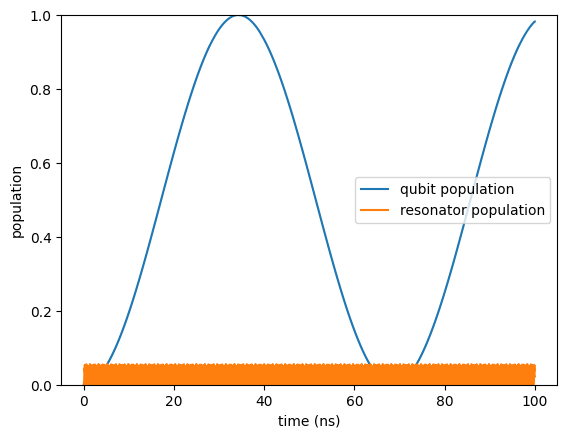

In [135]:
options = q.Options(rtol=1e-10, atol=1e-10, nsteps = 1000000000, store_states = True, store_final_state = True)
t_list = np.arange(0,100,1/wq/20) # One qubit Larmor cycle got 20 sampling points
c_ops = []
psi0 = q.tensor(q.basis(tmon_dim, 0), q.basis(res_dim, 0))
dr = 0.5
drive_list = np.ones(len(t_list)) * dr * np.cos(2*np.pi*wq*t_list)
drive_func = q.interpolate.Cubic_Spline(t_list[0],t_list[-1],drive_list)
H_driven = [H*2*np.pi, [(a_drive+a_drive.dag())*2*np.pi, drive_func]]
result = q.mesolve(H_driven, psi0, t_list, c_ops = c_ops, e_ops = [b.dag()*b, a.dag()*a], options = options)
plt.plot(t_list, result.expect[0], label='qubit population')
plt.plot(t_list, result.expect[1], label = 'resonator population')
plt.ylim(0,1)
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('population')

Text(0, 0.5, 'population')

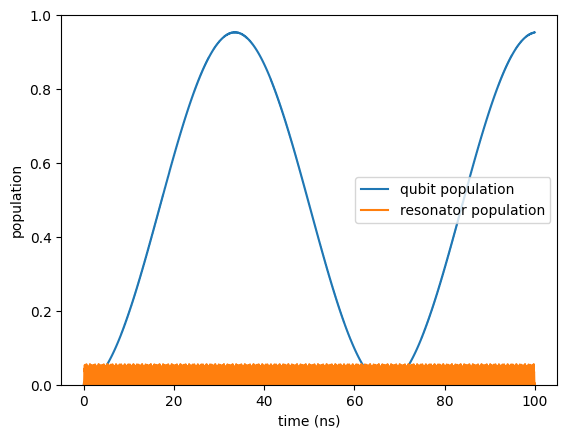

In [136]:
options = q.Options(rtol=1e-10, atol=1e-10, nsteps = 1000000000, store_states = True, store_final_state = True)
t_list = np.arange(0,100,1/wq/20) # One qubit Larmor cycle got 20 sampling points
c_ops = []
psi0 = q.tensor(q.basis(tmon_dim, 0), q.basis(res_dim, 0))
dr = 0.5
drive_list = np.ones(len(t_list)) * dr * np.cos(2*np.pi*(wq-0.003)*t_list)
drive_func = q.interpolate.Cubic_Spline(t_list[0],t_list[-1],drive_list)
H_driven = [H*2*np.pi, [(a_drive+a_drive.dag())*2*np.pi, drive_func]]
result = q.mesolve(H_driven, psi0, t_list, c_ops = c_ops, e_ops = [b.dag()*b, a.dag()*a], options = options)
plt.plot(t_list, result.expect[0], label='qubit population')
plt.plot(t_list, result.expect[1], label = 'resonator population')
plt.ylim(0,1)
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('population')

# Step 3: moving to a rotating frame

$H = (\omega_q-\omega_{qd}) \hat{b}^\dagger \hat{b} + \frac{\alpha}{2} \hat{b}^\dagger\hat{b}^\dagger \hat{b}\hat{b}  + 0\cdot\hat{a}^\dagger \hat{a} +\chi \hat{a}^\dagger\hat{a}\hat{b}^\dagger\hat{b}$

In [137]:
res_dim = 10
tmon_dim = 4
Ir = q.qeye(res_dim)
Iq = q.qeye(tmon_dim)
ar = q.destroy(res_dim)
bq = q.destroy(tmon_dim)
a = q.tensor(Iq, ar)
b = q.tensor(bq, Ir)
wd = wq + 0.001
H = ((wq-wd) * b.dag() * b + alpha * b.dag()*b.dag()*b*b/2 
     + 0 * a.dag() * a 
     + chi * a.dag()*a * b.dag() *b)

$a\rightarrow a\, e^{-i\omega_rt}$

$b\rightarrow b\, e^{-i\omega_{qd}t}$

If we drive the resonator at $\omega_{qd}$, we see the drving term

$\cos(\omega_{qd}t) \cdot a e^{-i\omega_rt}$ --  fast oscillating

$\cos(\omega_{qd}t) \cdot b e^{-i\omega_{qd}t} = (b + b e^{-i2\omega_{qd}t})/2$ 


Text(0, 0.5, 'population')

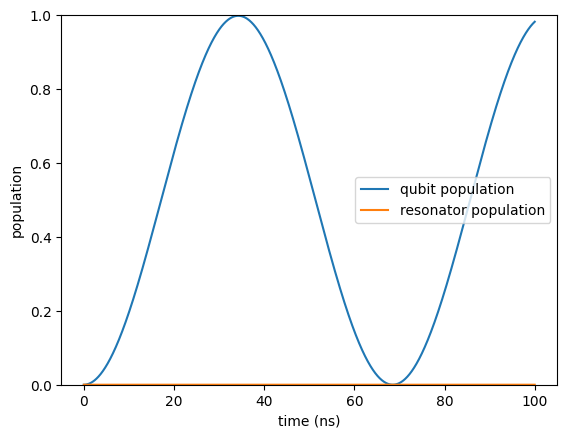

In [138]:
options = q.Options(rtol=1e-10, atol=1e-10, nsteps = 1000000000, store_states = True, store_final_state = True)
t_list = np.arange(0,100,1/wq/20) # One qubit Larmor cycle got 20 sampling points
c_ops = []
psi0 = q.tensor(q.basis(tmon_dim, 0), q.basis(res_dim, 0))
dr = 0.5 / 2
drive_list = np.ones(len(t_list)) * dr #* np.cos(2*np.pi*(wq-0.003)*t_list)
drive_func = q.interpolate.Cubic_Spline(t_list[0],t_list[-1],drive_list)
H_driven = [H*2*np.pi, [(a_drive+a_drive.dag())*2*np.pi, drive_func]] # previously
H_driven = [H*2*np.pi, [(b_coeff*b+b_coeff.conjugate()*b.dag())*2*np.pi, drive_func]] 

result = q.mesolve(H_driven, psi0, t_list, c_ops = c_ops, e_ops = [b.dag()*b, a.dag()*a], options = options)
plt.plot(t_list, result.expect[0], label='qubit population')
plt.plot(t_list, result.expect[1], label = 'resonator population')
plt.ylim(0,1)
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('population')

## Two-photon transition
 Drive the transmon at half of 0-2 transition frequency

Text(0, 0.5, 'population')

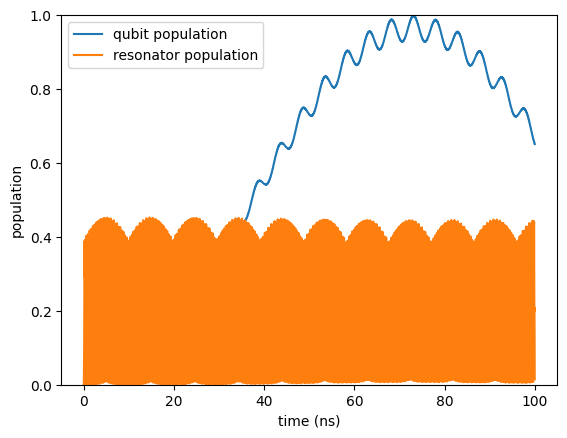

In [139]:
### Non-RWA
res_dim = 10
tmon_dim = 4
H = (wq * b.dag() * b + alpha * b.dag()*b.dag()*b*b/2 
     + wr * a.dag() * a 
     + chi * a.dag()*a * b.dag() *b)

a_drive = a_coeff * a+ b_coeff * b
wd = (2*wq + alpha)/2 ## (wq2-wq0)/2
dr = 1.5

options = q.Options(rtol=1e-10, atol=1e-10, nsteps = 1000000000, store_states = True, store_final_state = True)
t_list = np.arange(0,100,1/wq/20) # One qubit Larmor cycle got 20 sampling points
c_ops = []
psi0 = q.tensor(q.basis(tmon_dim, 0), q.basis(res_dim, 0))


drive_list = np.ones(len(t_list)) * dr * np.cos(2*np.pi*wd*t_list)
drive_func = q.interpolate.Cubic_Spline(t_list[0],t_list[-1],drive_list)
H_driven = [H*2*np.pi, [(a_drive+a_drive.dag())*2*np.pi, drive_func]]

result = q.mesolve(H_driven, psi0, t_list, c_ops = c_ops, e_ops = [b.dag()*b.dag()*b*b/2, a.dag()*a], options = options)
plt.plot(t_list, result.expect[0], label='qubit population')
plt.plot(t_list, result.expect[1], label = 'resonator population')
plt.ylim(0,1)
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('population')


Text(0.5, 1.0, 'RWA can be very off')

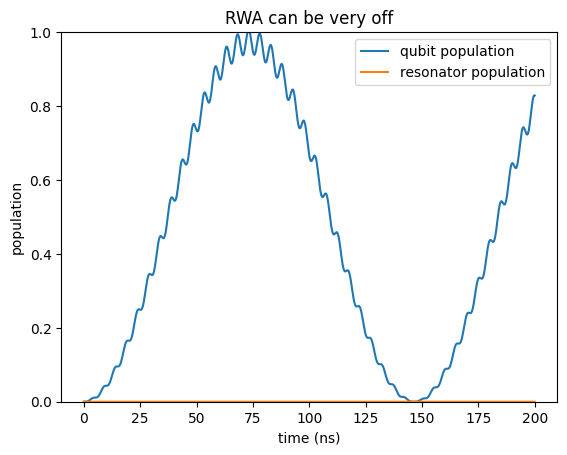

In [140]:
### RWA
wd = (2*wq + alpha)/2 ## (wq2-wq0)/2
H = ((wq-wd) * b.dag() * b + alpha * b.dag()*b.dag()*b*b/2 
     + 0 * a.dag() * a 
     + chi * a.dag()*a * b.dag() *b)

options = q.Options(rtol=1e-10, atol=1e-10, nsteps = 1000000000, store_states = True, store_final_state = True)
t_list = np.arange(0,200,1/wq/20) # One qubit Larmor cycle got 20 sampling points
c_ops = []
psi0 = q.tensor(q.basis(tmon_dim, 0), q.basis(res_dim, 0))
dr = 1.5 / 2
drive_list = np.ones(len(t_list)) * dr #* np.cos(2*np.pi*(wq-0.003)*t_list)
drive_func = q.interpolate.Cubic_Spline(t_list[0],t_list[-1],drive_list)
H_driven = [H*2*np.pi, [(a_drive+a_drive.dag())*2*np.pi, drive_func]] # previously
H_driven = [H*2*np.pi, [(b_coeff*b+b_coeff.conjugate()*b.dag())*2*np.pi, drive_func]] 

result = q.mesolve(H_driven, psi0, t_list, c_ops = c_ops, e_ops = [b.dag()*b.dag()*b*b/2, a.dag()*a], options = options)
plt.plot(t_list, result.expect[0], label='qubit population')
plt.plot(t_list, result.expect[1], label = 'resonator population')
plt.ylim(0,1)
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('population')
plt.title('RWA can be very off')

# Two-tone spectroscopy
Key point: move to a convenient rotating frame; find the whole system's steady state

Text(0, 0.5, 'transmission amplitude')

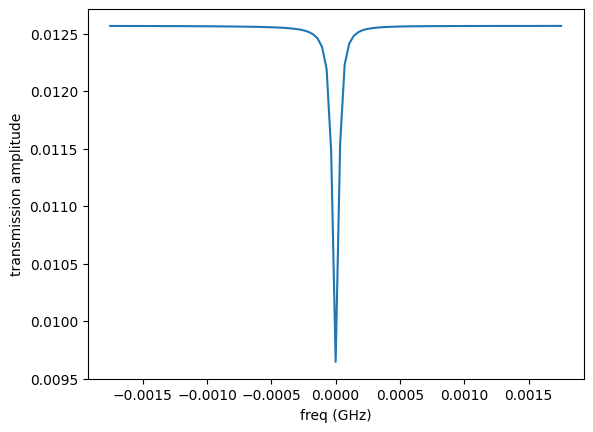

In [141]:
def H_func(wdq, wdr, dq, dr):
    H = ((wq-wdq) * b.dag() * b + alpha * b.dag()*b.dag()*b*b/2 
         + (wr-wdr) * a.dag() * a 
         + chi * a.dag()*a * b.dag() *b)
    H += (b.dag()+b) * dq
    H += (a.dag()+a) * dr
    return H
c_ops = [np.sqrt(1e-6)*b,np.sqrt(1e-6)*b.dag()*b, np.sqrt(1e-2)*a]
wdq_list = np.linspace(wq-chi*2,wq+chi*2,101)
transmission = np.zeros(len(wdq_list))
for n_ in range(len(transmission)):
    H = H_func(wdq_list[n_], wr, 0.00001, 0.00001)
    transmission[n_] = abs((q.steadystate(H*2*np.pi, c_ops) * a).tr())
plt.plot(wdq_list-wq, transmission)
plt.xlabel('freq (GHz)')
plt.ylabel('transmission amplitude')

Text(0, 0.5, 'transmission amplitude')

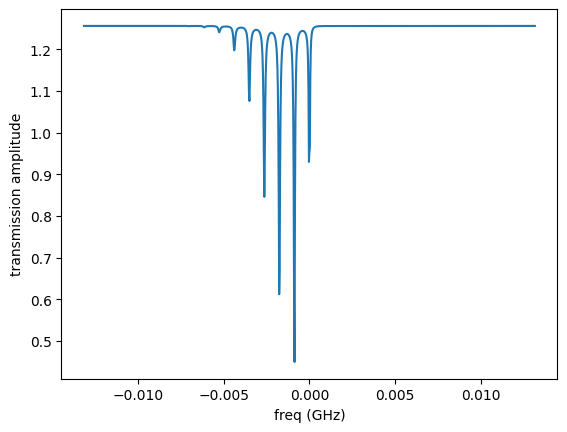

In [143]:
### Dave Schuster's number splitting
def H_func(wdq, wdr, dq, dr):
    H = ((wq-wdq) * b.dag() * b + alpha * b.dag()*b.dag()*b*b/2 
         + (wr-wdr) * a.dag() * a 
         + chi * a.dag()*a * b.dag() *b)
    H += (b.dag()+b) * dq
    H += (a.dag()+a) * dr
    return H
c_ops = [np.sqrt(1e-5)*b, np.sqrt(1e-4)*a]
wdq_list = np.linspace(wq-chi*15,wq+chi*15,1001)
transmission = np.zeros(len(wdq_list))
for n_ in range(len(transmission)):
    H = H_func(wdq_list[n_], wr, 0.00001, 0.00001)
    transmission[n_] = abs((q.steadystate(H*2*np.pi, c_ops) * a).tr())
plt.plot(wdq_list-wq, transmission)
plt.xlabel('freq (GHz)')
plt.ylabel('transmission amplitude')

Text(0, 0.5, 'transmission amplitude')

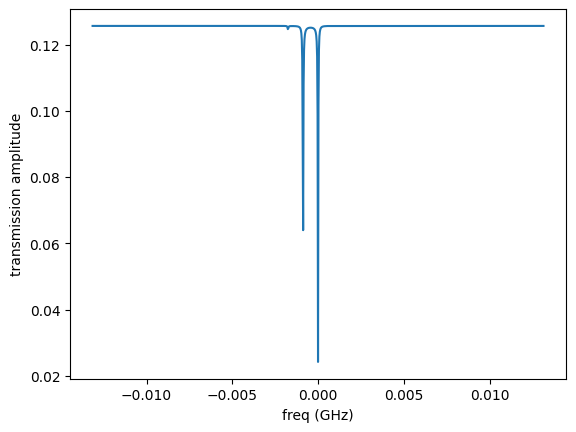

In [144]:
def H_func(wdq, wdr, dq, dr):
    H = ((wq-wdq) * b.dag() * b + alpha * b.dag()*b.dag()*b*b/2 
         + (wr-wdr) * a.dag() * a 
         + chi * a.dag()*a * b.dag() *b)
    H += (b.dag()+b) * dq
    H += (a.dag()+a) * dr
    return H
c_ops = [np.sqrt(1e-5)*b, np.sqrt(1e-4)*a]
wdq_list = np.linspace(wq-chi*15,wq+chi*15,1001)
transmission = np.zeros(len(wdq_list))
for n_ in range(len(transmission)):
    H = H_func(wdq_list[n_], wr, 0.00001, 0.000001)
    transmission[n_] = abs((q.steadystate(H*2*np.pi, c_ops) * a).tr())
plt.plot(wdq_list-wq, transmission)
plt.xlabel('freq (GHz)')
plt.ylabel('transmission amplitude')